In [203]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [204]:
import os
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
from comet_ml import Experiment
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

X_train shape:  (5791,)
X_val shape:  (1931,)
X_test shape:  (1931,)


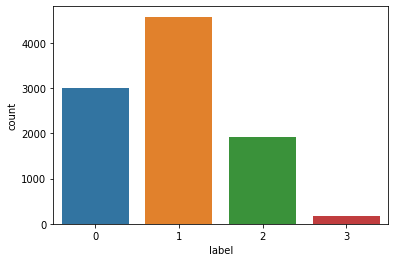

In [205]:
df = pd.read_csv('../data/tweets_50.csv')
X = df['text_tokenized']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)  # 0.8 * 0.25 = 0.2

class_names = y.unique().tolist()
# print("Class names: ", class_names)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
# TODO: save
sns.countplot(x=y);

In [206]:
batch_size = 128
max_tokens = 20_000
output_sequence_length= 400
embedding_dim = 50



def make_vectorizer(max_tokens: int, output_sequence_length: int) -> TextVectorization:
    vect = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length)
    text_ds = tf.data.Dataset.from_tensor_slices(X_train.values).batch(batch_size)
    vect.adapt(text_ds)
    return vect


def get_embedding_matrix(embedding_dim, num_tokens, word_index):
    path_to_glove_file = os.path.join(
        os.path.expanduser("~"), f"Documents/Datasets/glove.6B.{embedding_dim}d.txt"
    )
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print("Found {} word vectors.".format(len(embeddings_index)))
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def make_embedding_layer(voc: List[str], embedding_dim: int) -> layers.Embedding:
    word_index = dict(zip(voc, range(len(voc))))
    num_tokens = len(voc) + 2

    # just testing if word_index works
    test = ["the", "cat", "sat", "on", "the", "mat"]
    print("word_index test:")
    print(test, " --> ", [word_index[w] for w in test])

    embedding_matrix = get_embedding_matrix(embedding_dim, num_tokens, word_index)

    return layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )


vectorizer = make_vectorizer(max_tokens=max_tokens,
                             output_sequence_length=output_sequence_length)
vocabulary = vectorizer.get_vocabulary()
embedding_layer = make_embedding_layer(vocabulary, embedding_dim=embedding_dim)


word_index test:
['the', 'cat', 'sat', 'on', 'the', 'mat']  -->  [4, 1170, 2063, 17, 4, 8835]
Found 400000 word vectors.
Converted 18523 words (1477 misses)


In [207]:
epochs = 200
optimizer = 'adam'
activation = 'relu'
kernel_initializer = 'he_normal'
l2_lambda = 1e-2
dropout=0.5
filters = 128
n_convs_depth = 1
# kernel_size = 3
kernel_sizes = [2, 3]
n_convs_parallel = len(kernel_sizes)
pool_size = 5
strides = 1
# class_weight = {0: 1., 1: 1., 2: 1., 3: 1}
class_weight = None

def make_model():
    regularizers = keras.regularizers.l2(l2=l2_lambda)
    convs = []
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    embed = embedding_layer(x)
    for kernel_size in kernel_sizes:
        # for _ in range(n_convs_depth):
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation=activation,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=regularizers)(embed)
        x = layers.SpatialDropout1D(dropout)(x)
        x = layers.MaxPooling1D(pool_size=pool_size, strides=strides)(x)
        convs.append(layers.GlobalMaxPooling1D()(x))

    x = layers.Concatenate()(convs)
    x = layers.Dense(n_convs_parallel*filters, activation=activation, kernel_regularizer=regularizers)(x)
    x = layers.Dropout(dropout)(x)
    output_ = layers.Dense(len(class_names), activation="softmax")(x)
    model = keras.Model(string_input, output_)
    model.summary()

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
    )
    return model

In [208]:
project_name = 'nlp_embeddings_cnn'
experiment = Experiment(
    project_name=project_name,
    auto_param_logging=True,
    # auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
    api_key="HeH9EtfDC2KUlCOjeQaU1CuOM",
    workspace="henrystoll",
)
params = {
    'batch_size': batch_size,
    'max_tokens': max_tokens,
    'output_sequence_length': output_sequence_length,
    'embedding_dim': embedding_dim,
    'filters': filters,
    'kernel_sizes': kernel_sizes,
    'pool_size': pool_size,
    'strides': strides,
    'n_convs_depth': n_convs_depth,
    'n_convs_parallel': n_convs_parallel,
    'activation': activation,
    'kernel_initializer': kernel_initializer,
    'l2_lambda': l2_lambda,
    'dropout': dropout,
    'class_weight': class_weight,
    'optimizer': optimizer,
    'epochs': epochs,
}

experiment.log_parameters(params)

model = make_model()
keras.utils.plot_model(model, "model.png", show_shapes=True)
experiment.log_asset("model.png")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    verbose=1,
    restore_best_weights=True)

with experiment.train():
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        # class_weight=class_weight,
                        verbose=1,
                        callbacks=[early_stopping])

with experiment.test():
    loss, accuracy = model.evaluate(X_test, y_test)
    print(loss, accuracy)
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    experiment.log_metrics(metrics)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=1)
experiment.log_confusion_matrix(y_test.to_numpy(), y_predicted)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/henrystoll/nlp-embeddings-cnn/a47e167c2d604600b99e8787c52a58a6



Model: "model_933"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_27 (TextVect (None, 400)          0           input_30[0][0]                   
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 400, 50)      1000100     text_vectorization_27[0][0]      
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 399, 32)      3232        embedding_26[0][0]               
__________________________________________________________________________________________

COMET ERROR: File-like could not be uploaded


46/46 [==============================] - 4s 83ms/step - loss: 1.5358 - acc: 0.4656 - val_loss: 1.4782 - val_acc: 0.4821
Epoch 10/200
46/46 [==============================] - 4s 81ms/step - loss: 

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/henrystoll/nlp-embeddings-cnn/a47e167c2d604600b99e8787c52a58a6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_accuracy             : 0.4728120267391205
COMET INFO:     test_loss                 : 2.542945623397827
COMET INFO:     train_acc [12]            : (0.364013135433197, 0.47245725989341736)
COMET INFO:     train_batch_acc [60]      : (0.265625, 0.5234375)
COMET INFO:     train_batch_loss [60]     : (1.349818229675293, 6.759200096130371)
COMET INFO:     train_epoch_duration [12] : (3.731355011997948, 4.823405302999163)
COMET INFO:     train_loss [12]           : (1.34535813331604, 4.082757949829102)
COMET INFO:     train_val_acc [12]        : (0.4681512117385864, 0.4821335971355438)
COMET INFO:     train_val_loss [12]       :

In [209]:
# experiment.display(tab="confusion-matrices")